# Classifiers and Class Labels

This notebook explores how the classification score visualizers handle constraints when it comes to different types of models, data, class labeling schemes, and other parameters. In particular we explore the following:

Target Types:

- binary
- multiclass (3 classes)

Target Encoding:

- integers
- labels 

Labeling:

- list of classes
- LabelEncoder
- dict encoding
- list of more classes than values in y

In [1]:
%load_ext lab_black

In [2]:
# Use inline so that we can run the notebook multiple times
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

# Import all of the Yellowbrick classifiers
from yellowbrick.classifier import *
from yellowbrick.exceptions import YellowbrickError
from yellowbrick.datasets import load_game, load_occupancy

# Import scikit-learn utilities
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.model_selection import train_test_split as tts
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.datasets import make_classification

from collections import namedtuple
from functools import partial

Dataset = namedtuple("Dataset", "X,y,classes,encoder")
Split = namedtuple("Split", "train,test")


make_binary = partial(
    make_classification,
    n_samples=500,
    n_features=20,
    n_informative=8,
    n_redundant=2,
    n_classes=2,
    n_clusters_per_class=3,
)

make_multiclass = partial(
    make_classification,
    n_samples=500,
    n_features=20,
    n_informative=8,
    n_redundant=2,
    n_classes=6,
    n_clusters_per_class=3,
)

In [3]:
# Select the parameters to run against all models
# Then restart kernel and run all
MODEL = LogisticRegression(solver="lbfgs", multi_class="auto")
IS_FITTED = False
DATASET = "multiclass"
TARGET = "integers"
ENCODER = "labelencoder"
USE_PANDAS = False


def make_dataset(name=DATASET, target=TARGET, encoder=ENCODER, use_pandas=USE_PANDAS):
    loader = {
        "game": load_game,
        "occupancy": load_occupancy,
        "binary": make_binary,
        "multiclass": make_multiclass,
    }.get(name)

    if name in {"game", "occupancy"}:
        dataset = loader(return_dataset=True)
        labels = sorted(dataset.meta["labels"].items(), key=lambda i: i[1])

        if use_pandas:
            X, y = dataset.to_pandas()
        else:
            X, y = dataset.to_numpy()
    else:
        X, y = loader()
        labels = zip(list("abcdefghijk"), np.unique(y))

    if name == "game":
        X = OneHotEncoder().fit_transform(X)

    # game target is string encoded, occupancy is integer encoded
    if target == "integers":
        if y.dtype.kind != "i":
            y = LabelEncoder().fit_transform(y)
    elif target == "labels":
        if y.dtype.kind == "i":
            rv = {i[1]: i[0] for i in labels.items()}
            y = np.array([rv[yi] for yi in y])
    else:
        raise ValueError(f"unknown target type '{target}', use integers or labels")

    c, le = None, None
    X_train, X_test, y_train, y_test = tts(
        X, y, test_size=0.2, shuffle=True, stratify=y
    )

    if encoder == "list":
        c = [l[0] for l in labels]
    elif encoder == "labelencoder":
        le = LabelEncoder().fit([l[0] for l in labels])
    elif encoder == "dict":
        le = {l[1]: l[0] for l in labels}
    elif encoder is None:
        c, le = None, None
    else:
        raise ValueError(
            f"unknown encoder type '{encoder}', see make_dataset for choices"
        )

    return Dataset(Split(X_train, X_test), Split(y_train, y_test), c, le)


def visualize(visualizer, model=MODEL, is_fitted=IS_FITTED, score=True):
    if is_fitted:
        # This includes both auto and True; fit the model manually if you want the exception raised
        model = model.fit(dataset.X.train, dataset.y.train)
    _, ax = plt.subplots(figsize=(9, 6))

    try:
        oz = visualizer(
            model,
            ax=ax,
            classes=dataset.classes,
            encoder=dataset.encoder,
            is_fitted=is_fitted,
        )
        oz.fit(dataset.X.train, dataset.y.train)

        if score:
            oz.score(dataset.X.test, dataset.y.test)

        oz.finalize()
    except YellowbrickError as e:
        print(e)
    except Exception as e:
        print("A NON YB ERROR OCCURRED:")
        print(e)
    return oz


dataset = make_dataset()

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


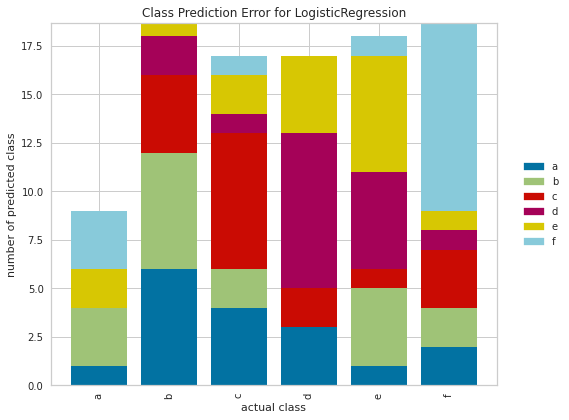

In [4]:
oz = visualize(ClassPredictionError)

In [5]:
oz.score_

0.38

dict_keys(['ax', 'classes', 'cmap', 'encoder', 'estimator', 'force_model', 'is_fitted', 'support']) 


dict_keys(['ax', 'classes', 'cmap', 'encoder', 'estimator', 'force_model', 'is_fitted', 'support']) 




ClassificationReport(ax=<AxesSubplot:title={'center':'LogisticRegression Classification Report'}>,
                     cmap=<matplotlib.colors.ListedColormap object at 0x7fb5fdfe90d0>,
                     encoder=LabelEncoder(), estimator=LogisticRegression(),
                     is_fitted=False)

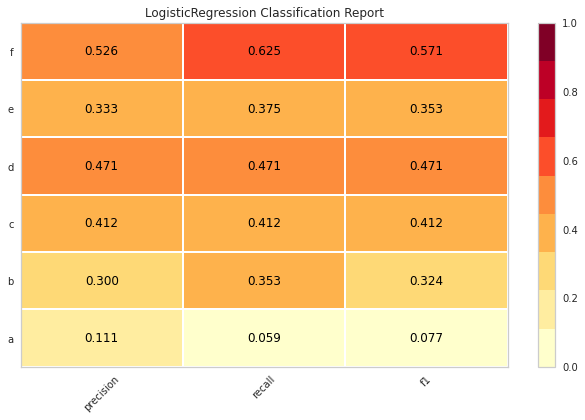

In [6]:
visualize(ClassificationReport)

dict_keys(['ax', 'classes', 'cmap', 'encoder', 'estimator', 'fontsize', 'force_model', 'is_fitted', 'percent', 'sample_weight']) 


dict_keys(['ax', 'classes', 'cmap', 'encoder', 'estimator', 'fontsize', 'force_model', 'is_fitted', 'percent', 'sample_weight']) 




ConfusionMatrix(ax=<AxesSubplot:title={'center':'LogisticRegression Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>,
                cmap=<matplotlib.colors.ListedColormap object at 0x7fb5fdf262b0>,
                encoder=LabelEncoder(), estimator=LogisticRegression(),
                is_fitted=False)

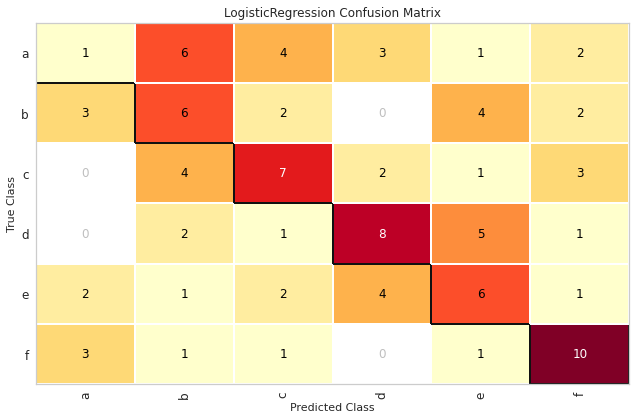

In [7]:
visualize(ConfusionMatrix)

dict_keys(['ap_score', 'ax', 'classes', 'cmap', 'colors', 'encoder', 'estimator', 'fill_area', 'fill_opacity', 'force_model', 'is_fitted', 'iso_f1_curves', 'iso_f1_values', 'line_opacity', 'micro', 'per_class']) 


dict_keys(['ap_score', 'ax', 'classes', 'cmap', 'colors', 'encoder', 'estimator', 'fill_area', 'fill_opacity', 'force_model', 'is_fitted', 'iso_f1_curves', 'iso_f1_values', 'line_opacity', 'micro', 'per_class']) 




PrecisionRecallCurve(ax=<AxesSubplot:title={'center':'Precision-Recall Curve for LogisticRegression'}, xlabel='Recall', ylabel='Precision'>,
                     encoder=LabelEncoder(),
                     estimator=OneVsRestClassifier(estimator=LogisticRegression()),
                     is_fitted=False, iso_f1_values={0.2, 0.4, 0.6, 0.8})

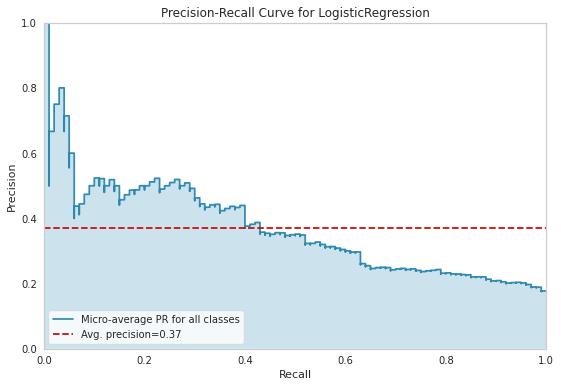

In [8]:
visualize(PRCurve)

AttributeError: 'LogisticRegression' object has no attribute 'binary'

AttributeError: 'LogisticRegression' object has no attribute 'binary'

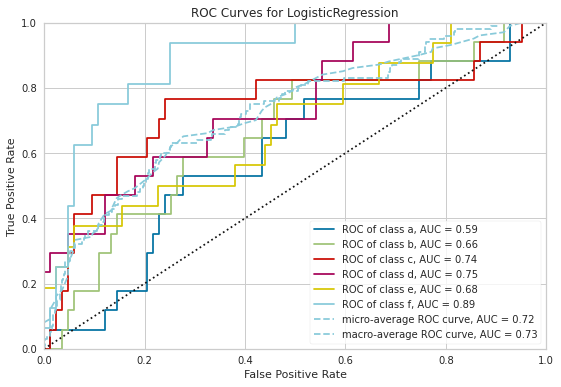

In [9]:
visualize(ROCAUC)

multiclass format is not supported


AttributeError: 'LogisticRegression' object has no attribute 'force_model'

AttributeError: 'LogisticRegression' object has no attribute 'force_model'

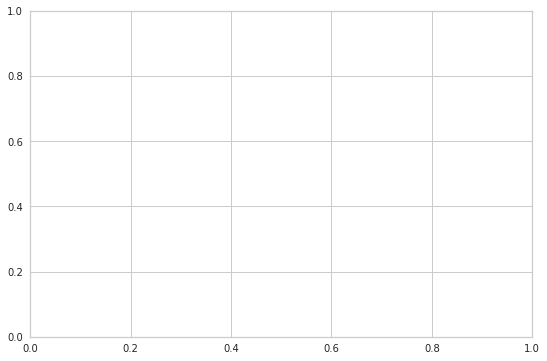

In [10]:
visualize(DiscriminationThreshold, score=False)